# Análisis Estadístico y Predicción de Casos de Covid-19 en México

El objetivo de esta notebook es explorar los datos de casos de Covid-19 en México con el objetivo de realizar un análisis estadístico de sus variables, así como predecir si un paciente está contagiado o no con Covid en base a las variables independientes del sistema.

## 1. Exploración de los datos

### 1.1. Análisis de la distribución de la variable dependiente

El primer paso de la exploración de los datos es asegurarse de que existe un balance en la distribución de personas de acuerdo a la variable objetivo o variable dependiente.

In [1]:
import base64
from IPython.display import HTML
from scipy import stats
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
import matplotlib.pyplot as plt
from fitter import Fitter, get_distributions
warnings.filterwarnings('ignore')

Descripción superficial del dataset.

## 2. Clasificación binaria utilizando CatBoost

*Las siguientes celdas leen y le dan formato a los datasets utilizados en esta notebook en caso de que se quiera correr una sesión a partir de este capítulo.*

In [2]:
df = pd.read_csv('mexico_covid19.csv')
covid_data = pd.read_csv('covid_data.csv')

In [3]:
df = df.loc[:, covid_data.columns]
df = df[[columna for columna in df if columna not in ['RESULTADO']] + ['RESULTADO']]
df.head()

,EDAD,SEXO,NEUMONIA,DIABETES,EPOC,ASMA,INMUSUPR,HIPERTENSION,OTRA_COM,CARDIOVASCULAR,OBESIDAD,RENAL_CRONICA,TABAQUISMO,OTRO_CASO,RESULTADO
0,74,2,2,1,2,2,2,1,2,2,1,2,2,2,2
1,71,1,2,1,1,2,2,1,2,2,1,2,1,99,2
2,50,2,1,2,2,2,2,2,2,2,2,2,2,99,1
3,25,1,2,2,2,2,2,2,2,2,1,2,2,99,1
4,28,1,2,2,2,2,2,2,2,2,2,2,2,99,2


In [4]:
covid_data.head()

,EDAD,SEXO,NEUMONIA,DIABETES,EPOC,ASMA,INMUSUPR,HIPERTENSION,OTRA_COM,CARDIOVASCULAR,OBESIDAD,RENAL_CRONICA,TABAQUISMO,OTRO_CASO,RESULTADO
0,74,2,2,1,2,2,2,1,2,2,1,2,2,2,2
1,71,1,2,1,1,2,2,1,2,2,1,2,1,2,2
2,50,2,1,2,2,2,2,2,2,2,2,2,2,1,1
3,25,1,2,2,2,2,2,2,2,2,1,2,2,1,1
4,28,1,2,2,2,2,2,2,2,2,2,2,2,1,2


### 2.1. División de los datos

Para comprobar que el balance del dataframe tuvo un impacto positivo en la ejecución del algoritmo se entrenará el algoritmo en los datos filtrados, así como en el dataset con datos simulados para comparar la precisión en ambos casos.

In [5]:
from sklearn.model_selection import train_test_split

X = df.drop('RESULTADO', axis=1)
y = df.RESULTADO

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1010)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=1010)

print(f'Tamaños de los sets:\nEntrenamiento: {len(X_train)}\tValidación: {len(X_val)}\tPrueba: {len(X_test)}')

Tamaños de los sets:
Entrenamiento: 210405	Validación: 26301	Prueba: 26301


In [6]:
covX = covid_data.drop('RESULTADO', axis=1)
covy = covid_data.RESULTADO

covX_train, covX_test, covy_train, covy_test = train_test_split(covX, covy, test_size=0.2, random_state=1010)
covX_val, covX_test, covy_val, covy_test = train_test_split(covX_test, covy_test, test_size=0.5, random_state=1010)

print(f'Tamaños de los sets:\nEntrenamiento: {len(covX_train)}\tValidación: {len(covX_val)}\tPrueba: {len(covX_test)}')

Tamaños de los sets:
Entrenamiento: 254180	Validación: 31773	Prueba: 31773


Debido a la enorme cantidad de atributos categóricos dentro del dataset, se optó por utilizar [CatBoost](https://catboost.ai/) para realizar la clasificación de pacientes que estén o no contagiados de Covid. `CatBoost` es un algoritmo de boosting que requiere poco o nulo preprocesamiento de las variables categóricas del dataset sobre el cual va a operar, por lo que es perfecto para los fines de este proyecto.

### 2.2.  Generación del modelo con los datos del dataframe original

In [7]:
from catboost import CatBoostClassifier, Pool

cat_features = [x for x in range(1, len(covid_data.columns) - 1)]

train_data = Pool(data=X_train,
                  label=y_train,
                  cat_features=cat_features)

eval_data = Pool(data=X_val,
                 label=y_val,
                 cat_features=cat_features)

model = CatBoostClassifier(iterations=1000, task_type='GPU', learning_rate=0.1, random_seed=1010)
model.fit(train_data, eval_set=eval_data, verbose=100, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6811844	test: 0.6809539	best: 0.6809539 (0)	total: 62.8ms	remaining: 1m 2s
100:	learn: 0.6212228	test: 0.6224532	best: 0.6224532 (100)	total: 4.84s	remaining: 43.1s
200:	learn: 0.6199328	test: 0.6221948	best: 0.6221948 (200)	total: 9.74s	remaining: 38.7s
300:	learn: 0.6188054	test: 0.6221999	best: 0.6221563 (238)	total: 14.7s	remaining: 34.1s
400:	learn: 0.6178357	test: 0.6222992	best: 0.6221563 (238)	total: 19.8s	remaining: 29.5s
500:	learn: 0.6170644	test: 0.6223633	best: 0.6221563 (238)	total: 24.8s	remaining: 24.7s
600:	learn: 0.6162912	test: 0.6224877	best: 0.6221563 (238)	total: 29.9s	remaining: 19.9s
700:	learn: 0.6155327	test: 0.6226029	best: 0.6221563 (238)	total: 35s	remaining: 14.9s
800:	learn: 0.6148933	test: 0.6228176	best: 0.6221563 (238)	total: 40s	remaining: 9.94s
900:	learn: 0.6142675	test: 0.6229065	best: 0.6221563 (238)	total: 45.1s	remaining: 4.95s
999:	learn: 0.6136312	test: 0.6230130	best: 0.6221563 (238)	total: 50.2s	remaining: 0us
bestTest = 0.622156

In [8]:
from sklearn.metrics import accuracy_score, confusion_matrix

# Función que imprime la precisión y la matríz de confusión del modelo
def print_results(model, train_data, val_data, test_data):
    y_hat = model.predict(test_data[0])

    precision = [accuracy_score(y_pred=model.predict(train_data[0]), y_true=train_data[1]) * 100,
                 accuracy_score(y_pred=model.predict(val_data[0]), y_true=val_data[1]) * 100,
                 accuracy_score(y_pred=y_hat, y_true=test_data[1]) * 100]

    print(f'Precisión del modelo sobre los sets de...\nEntrenamiento: {precision[0]:.2f}%\nValidación: {precision[1]:.2f}%\nPrueba: {precision[2]:.2f}%')
    
    cm = confusion_matrix(y_hat, test_data[1])

    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_percentages = [f'{value:.2%}' for value in cm.flatten()/np.sum(cm)]
    labels = [f'{name}\n{percent}' for name, percent in zip(group_names, group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')
    ax.set_title('\nMatríz de Confusión')
    ax.set_xlabel('\nValores Predecidos')
    ax.set_ylabel('Valores Reales')
    ax.xaxis.set_ticklabels(['False','True'])
    ax.yaxis.set_ticklabels(['False','True'])

    plt.show()

Precisión del modelo sobre los sets de...
Entrenamiento: 66.58%
Validación: 66.35%
Prueba: 66.22%


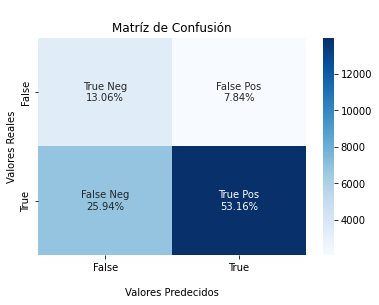

In [9]:
print_results(model, (X_train, y_train), (X_val, y_val), (X_test, y_test))

Se observa que el modelo generaliza adecuadamente sobre los sets de validación y prueba, y que cuenta con un porcentaje de precisión favorable.

### 2.3. Generación del modelo con los datos de "covid_data"

In [10]:
cov_train_data = Pool(data=covX_train,
                  label=covy_train,
                  cat_features=cat_features)

cov_eval_data = Pool(data=covX_val,
                 label=covy_val,
                 cat_features=cat_features)

cov_model = CatBoostClassifier(iterations=1000, task_type='GPU', learning_rate=0.1, random_seed=1010)
cov_model.fit(cov_train_data, eval_set=cov_eval_data, verbose=100, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6521485	test: 0.6523587	best: 0.6523587 (0)	total: 9.24ms	remaining: 9.23s
100:	learn: 0.5201478	test: 0.5240022	best: 0.5240022 (100)	total: 765ms	remaining: 6.8s
200:	learn: 0.5180598	test: 0.5229715	best: 0.5229692 (199)	total: 1.53s	remaining: 6.07s
300:	learn: 0.5168172	test: 0.5228423	best: 0.5227873 (270)	total: 2.27s	remaining: 5.26s
400:	learn: 0.5158066	test: 0.5227309	best: 0.5226566 (362)	total: 2.98s	remaining: 4.46s
500:	learn: 0.5150187	test: 0.5227539	best: 0.5226566 (362)	total: 3.74s	remaining: 3.73s
600:	learn: 0.5142937	test: 0.5227489	best: 0.5226566 (362)	total: 4.51s	remaining: 3s
700:	learn: 0.5137036	test: 0.5228730	best: 0.5226566 (362)	total: 5.23s	remaining: 2.23s
800:	learn: 0.5131509	test: 0.5229701	best: 0.5226566 (362)	total: 5.94s	remaining: 1.48s
900:	learn: 0.5125682	test: 0.5230414	best: 0.5226566 (362)	total: 6.64s	remaining: 730ms
999:	learn: 0.5120438	test: 0.5230779	best: 0.5226566 (362)	total: 7.37s	remaining: 0us
bestTest = 0.522656

Precisión del modelo sobre los sets de...
Entrenamiento: 72.06%
Validación: 71.48%
Prueba: 71.67%


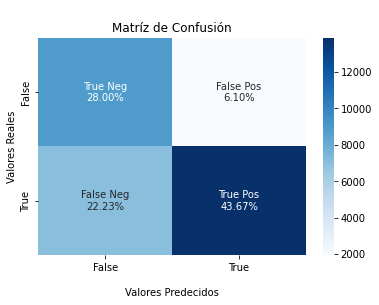

In [11]:
print_results(cov_model, (covX_train, covy_train), (covX_val, covy_val), (covX_test, covy_test))

Se puede observar como bajo las mismas condiciones de entrenamiento que el modelo utilizado sobre el dataset original, la precisión del modelo sobre los datos enriquecidos con simulación es 20% más alta, y cuenta con menos casos de Falsos Negativos y Falsos Positivos que el modelo anterior.

## 3. Ajuste de hiperparámetros utilizando Grid Search

Los resultados de los modelos anteriores son buenos, pero existe la posibilidad de mejorar la precisión sobre ambos grupos de datos a través de un ajuste de hiperparámetros, el cual se realizará utilizando el método de `grid_search` del anterior usado **CatBoostClassifier**.

### 3.1. Definición de los hiperparámetros

A continuación se definen los hiperparámetros estáticos y los hiperparámetros que se utilizarán en el Grid Search.

In [20]:
static_params = {
    'task_type'     : 'GPU',
    'random_seed'   : 1010,
    'loss_function' : 'Logloss',
    'verbose'       : False,
    'od_type'       : 'Iter',
    'od_wait'       : 200,
    'eval_metric'   :'Accuracy'
}

grid_params = {
    'depth'            : [4, 5, 6, 7, 8, 9, 10],
    'learning_rate'    : [0.001, 0.01, 0.03, 0.1, 0.2],
    'iterations'       : [100, 250, 500, 1000, 2000]
}

grid_model = CatBoostClassifier(**static_params)
cov_grid_model = CatBoostClassifier(**static_params)

### 3.1. Aplicación del modelo con grid search sobre dataframe original

A continuación se crea alimentan los datos al modelo con Grid Search a través del método de **Pool**, así como el diccionario de hiperparámetros definidos en la celda anterior. Una vez terminado el Grid Search, la variable `grid_result` contendrá los mejores valores con los que se entrenó `grid_model`.

In [13]:
train_data = Pool(data=X_train,
                  label=y_train,
                  cat_features=cat_features)

grid_result = grid_model.grid_search(param_grid=grid_params, X=train_data, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

bestTest = 0.6203987548
bestIteration = 0
0:	loss: 0.6203988	best: 0.6203988 (0)	total: 2.66s	remaining: 7m 42s
bestTest = 0.6405028398
bestIteration = 99
1:	loss: 0.6405028	best: 0.6405028 (1)	total: 5.34s	remaining: 7m 41s
bestTest = 0.6538817994
bestIteration = 98
2:	loss: 0.6538818	best: 0.6538818 (2)	total: 7.99s	remaining: 7m 37s
bestTest = 0.6604881063
bestIteration = 99
3:	loss: 0.6604881	best: 0.6604881 (3)	total: 10.6s	remaining: 7m 34s
bestTest = 0.6607970343
bestIteration = 97
4:	loss: 0.6607970	best: 0.6607970 (4)	total: 13.2s	remaining: 7m 29s
bestTest = 0.6468239823
bestIteration = 1
5:	loss: 0.6468240	best: 0.6607970 (4)	total: 22.6s	remaining: 10m 35s
bestTest = 0.6548798745
bestIteration = 249
6:	loss: 0.6548799	best: 0.6607970 (4)	total: 33.9s	remaining: 13m 33s
bestTest = 0.6603455241
bestIteration = 249
7:	loss: 0.6603455	best: 0.6607970 (4)	total: 45.2s	remaining: 15m 43s
bestTest = 0.6617000547
bestIteration = 115
8:	loss: 0.6617001	best: 0.6617001 (8)	total: 55.

In [14]:
grid_result['params']

{'depth': 10, 'iterations': 250, 'learning_rate': 0.2}

De acuerdo a los resultados del `grid search`, los mejores hiperparámetros para entrenar el modelo son:
- Árboles con 10 niveles de profundidad
- 250 iteraciones
- Con una taza de aprendizaje de 0.2

A continuación se utilizarán los hiperparámetros obtenidos para entrenar un nuevo modelo utilizando también el set de validación de los datos del dataset original.

In [17]:
eval_data = Pool(data=X_val,
                 label=y_val,
                 cat_features=cat_features)

best_model = CatBoostClassifier(**grid_result['params'])
best_model.fit(train_data, eval_set=eval_data, use_best_model=True, verbose=100, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6729628	test: 0.6727463	best: 0.6727463 (0)	total: 152ms	remaining: 37.7s
100:	learn: 0.6135015	test: 0.6229014	best: 0.6227694 (38)	total: 24.5s	remaining: 36.2s
200:	learn: 0.6082385	test: 0.6239435	best: 0.6227694 (38)	total: 53.6s	remaining: 13.1s
249:	learn: 0.6055725	test: 0.6244990	best: 0.6227694 (38)	total: 1m 8s	remaining: 0us

bestTest = 0.6227693656
bestIteration = 38

Shrink model to first 39 iterations.


### 3.2. Comparación del desempeño

Precisión del modelo sobre los sets de...
Entrenamiento: 66.58%
Validación: 66.35%
Prueba: 66.22%


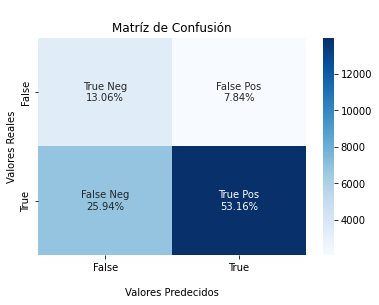

In [9]:
print_results(model, (X_train, y_train), (X_val, y_val), (X_test, y_test))

Precisión del modelo sobre los sets de...
Entrenamiento: 66.86%
Validación: 66.22%
Prueba: 66.08%


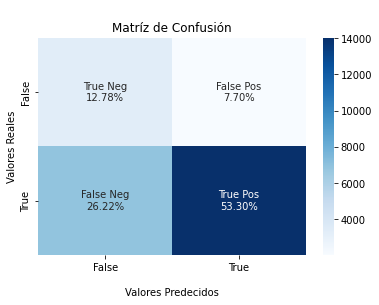

In [18]:
print_results(best_model, (X_train, y_train), (X_val, y_val), (X_test, y_test))

En las dos celdas de arriba se puede observar el desempeño del modelo entrenado inicialmente con los datos originales, así como el desempeño del modelo entrenado con los hiperparámetros obtenidos a través del método de `grid search`. Al realizar una comparación se puede notar como ambos modelos cuentan con un desempeño similar, con el primer modelo teniendo una precisión ligeramente más homogénea a través de los diferentes sets de datos. Por su parte, el modelo `best_model` presenta una puntuación ligeramente mejor en la detección de **Verdaderos Positivos** y **Falsos Positivos**, al costo de un desempeño ligeramente peor en cuanto a los casos negativos se trata.

Basado en este análisis, ambos modelos son prácticamente intercambiables, siendo el primer modelo ligeramente superior al entrenado con los parámetos obtenidos durante el proceso de grid search.

### 3.3. Aplicación del modelo con grid search sobre dataframe "covid_data"

En las siguientes celdas se repetirán los procedimientos anteriormente realizados para encontrar los mejores hiperparámetros para el modelo que recibirá el dataframe que también contiene los datos simulados.

In [21]:
cov_train_data = Pool(data=covX_train,
                  label=covy_train,
                  cat_features=cat_features)

cov_grid_result = cov_grid_model.grid_search(param_grid=grid_params, X=cov_train_data, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

bestTest = 0.7095955622
bestIteration = 1
0:	loss: 0.7095956	best: 0.7095956 (0)	total: 2.21s	remaining: 6m 23s
bestTest = 0.7103824062
bestIteration = 99
1:	loss: 0.7103824	best: 0.7103824 (1)	total: 4.33s	remaining: 6m 14s
bestTest = 0.7112479345
bestIteration = 97
2:	loss: 0.7112479	best: 0.7112479 (2)	total: 6.5s	remaining: 6m 12s
bestTest = 0.7156345897
bestIteration = 95
3:	loss: 0.7156346	best: 0.7156346 (3)	total: 8.62s	remaining: 6m 8s
bestTest = 0.7162050515
bestIteration = 90
4:	loss: 0.7162051	best: 0.7162051 (4)	total: 10.7s	remaining: 6m 4s
bestTest = 0.7095955622
bestIteration = 1
5:	loss: 0.7095956	best: 0.7162051 (4)	total: 15s	remaining: 7m 2s
bestTest = 0.7110708946
bestIteration = 237
6:	loss: 0.7110709	best: 0.7162051 (4)	total: 20.2s	remaining: 8m 4s
bestTest = 0.7151624833
bestIteration = 231
7:	loss: 0.7151625	best: 0.7162051 (4)	total: 25.3s	remaining: 8m 47s
bestTest = 0.7167165001
bestIteration = 159
8:	loss: 0.7167165	best: 0.7167165 (8)	total: 30s	remaining

In [24]:
cov_grid_result['params']

{'depth': 10, 'iterations': 2000, 'learning_rate': 0.03}

De acuerdo a los resultados del `grid search`, los mejores hiperparámetros para entrenar el modelo son:
- Árboles con 10 niveles de profundidad
- 250 iteraciones
- Con una taza de aprendizaje de 0.2

A continuación se utilizarán los hiperparámetros obtenidos para entrenar un nuevo modelo utilizando también el set de validación de los datos del dataset original.

In [25]:
cov_eval_data = Pool(data=covX_val,
                 label=covy_val,
                 cat_features=cat_features)

best_cov_model = CatBoostClassifier(**cov_grid_result['params'])
best_cov_model.fit(cov_train_data, eval_set=cov_eval_data, use_best_model=True, verbose=100, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6759926	test: 0.6761371	best: 0.6761371 (0)	total: 41.4ms	remaining: 1m 22s
100:	learn: 0.5168638	test: 0.5227993	best: 0.5227993 (100)	total: 3.45s	remaining: 1m 4s
200:	learn: 0.5135688	test: 0.5219889	best: 0.5219824 (193)	total: 6.56s	remaining: 58.7s
300:	learn: 0.5116080	test: 0.5220044	best: 0.5219422 (209)	total: 9.53s	remaining: 53.8s
400:	learn: 0.5098472	test: 0.5221857	best: 0.5219422 (209)	total: 12.6s	remaining: 50.4s
500:	learn: 0.5083742	test: 0.5224701	best: 0.5219422 (209)	total: 15.9s	remaining: 47.6s
600:	learn: 0.5071501	test: 0.5229141	best: 0.5219422 (209)	total: 19.3s	remaining: 44.8s
700:	learn: 0.5061286	test: 0.5232587	best: 0.5219422 (209)	total: 22.9s	remaining: 42.4s
800:	learn: 0.5052169	test: 0.5236549	best: 0.5219422 (209)	total: 26.1s	remaining: 39.1s
900:	learn: 0.5043256	test: 0.5239577	best: 0.5219422 (209)	total: 29.4s	remaining: 35.9s
1000:	learn: 0.5035443	test: 0.5243232	best: 0.5219422 (209)	total: 32.9s	remaining: 32.8s
1100:	learn

### 3.4. Comparación del desempeño

Precisión del modelo sobre los sets de...
Entrenamiento: 72.06%
Validación: 71.48%
Prueba: 71.67%


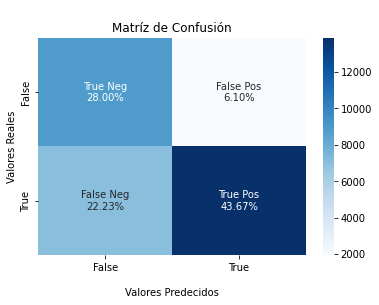

In [11]:
print_results(cov_model, (covX_train, covy_train), (covX_val, covy_val), (covX_test, covy_test))

Precisión del modelo sobre los sets de...
Entrenamiento: 72.33%
Validación: 71.50%
Prueba: 71.56%


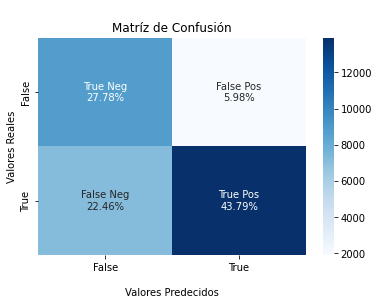

In [26]:
print_results(best_cov_model, (covX_train, covy_train), (covX_val, covy_val), (covX_test, covy_test))

Similarmente como en el caso de los modelos anteriores, el rendimiento entre los modelos entrenados con los datos enriquecidos es extremadamente similar, siendo en este caso el modelo entrenado con los hiperparámetros obtenidos con grid search ligeramente superior ya que presenta un buen nivel de generalización en sus valores de precisión, así como un ligero incremento en la detección de **Verdaderos Positivos**.

Debido a que ambos modelos presentan problemas en la detección de **valores negativos** es necesario realizar un análisis de más profundo a ambos sets de datos para corregir dicho problema.

## 4. Conclusiones y futuros análisis

A pesar de que los dos modelos fueron alimentados sets de datos distintos, ambos consiguieron generalizar perfectamente su precisión através de los diferentes sets de datos. Sin embargo, ambos tienen un problema con los resultados de los Falsos Negativos. Un análisis más profundos de los datos es requerido para obtener unos resultados más satisfactorios.

Finalmente, utilizando el modelo entrenado con datos enriquecidos o un modelo más confiable, en caso de obtenerse uno, sería posible, a través de simulaciones, analizar el impacto de un cada variable en la predicción de casos positivos en un grupo de pacientes.